In [1]:
import pandas as pd
import numpy as np
import os
import time

from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm


In [19]:
# === File paths ===
DATA_PATH = "../../../ieee-fraud-detection/"
TRAIN_TRANS_FILE = "train_transaction.csv"
TRAIN_IDENTITY_FILE = "train_identity.csv"
TEST_TRANS_FILE = "test_transaction.csv"
TEST_IDENTITY_FILE = "test_identity.csv"

# === Load Data ===
def load_data():
    print("Loading train and test data...")

    train_transaction = pd.read_csv(os.path.join(DATA_PATH, TRAIN_TRANS_FILE))
    train_identity = pd.read_csv(os.path.join(DATA_PATH, TRAIN_IDENTITY_FILE))
    train = pd.merge(train_transaction, train_identity, how="left", on="TransactionID")

    test_transaction = pd.read_csv(os.path.join(DATA_PATH, TEST_TRANS_FILE))
    test_identity = pd.read_csv(os.path.join(DATA_PATH, TEST_IDENTITY_FILE))
    test = pd.merge(test_transaction, test_identity, how="left", on="TransactionID")

    return train, test

# Load data
train_raw, test_raw = load_data()
train_raw.shape, test_raw.shape


Loading train and test data...


((590540, 434), (506691, 433))

In [20]:
def get_column_types(df):
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
    return numerical_cols, categorical_cols


In [21]:
def iterative_impute_fast(df, columns, max_iter=5, sample_frac=0.1, verbose=True):
    df = df.copy()
    if verbose:
        print(f"\n⚡ Fast Iterative Imputation: {len(columns)} columns | Sample: {sample_frac*100:.0f}% | Estimator: DecisionTree\n")

    sample_df = df[columns].sample(frac=sample_frac, random_state=42)

    imputer = IterativeImputer(
        estimator=DecisionTreeRegressor(max_depth=5),
        max_iter=max_iter,
        random_state=42,
        verbose=0
    )

    imputer.fit(sample_df)
    df[columns] = imputer.transform(df[columns])

    print(" Fast iterative imputation complete.\n")
    return df


In [22]:
def clean_data(df, target_column='isFraud'):
    print(" Cleaning data...")
    df = df.copy()
    numerical_cols, categorical_cols = get_column_types(df)

    if target_column in numerical_cols:
        numerical_cols.remove(target_column)

    # Calculate missing ratios
    missing_ratios = df[numerical_cols].isnull().mean()

    # Segmentation by % missing
    iter_missing = missing_ratios[missing_ratios < 0.10].index.tolist()
    mean_missing = missing_ratios[(missing_ratios >= 0.10) & (missing_ratios < 0.35)].index.tolist()
    median_missing = missing_ratios[(missing_ratios >= 0.35) & (missing_ratios <= 0.70)].index.tolist()
    high_missing = missing_ratios[missing_ratios > 0.70].index.tolist()

    print(f"Dropping {len(high_missing)} columns with >70% missing values...")
    df.drop(columns=high_missing, inplace=True)

    # Iterative Imputer for very low-missing features
    if iter_missing:
        print(f"Iteratively imputing {len(iter_missing)} columns (<10% missing)...")
        t0 = time.time()
        df = iterative_impute_fast(df, iter_missing, max_iter=5, sample_frac=0.1, verbose=True)
        print(f" Iterative imputation complete in {time.time() - t0:.2f} seconds.\n")

    # Mean Imputer for moderate-missing features
    if mean_missing:
        print(f" Applying Mean Imputer to {len(mean_missing)} columns (10–35% missing)...")
        t1 = time.time()
        mean_imp = SimpleImputer(strategy='mean')
        df[mean_missing] = mean_imp.fit_transform(df[mean_missing])
        print(f" Mean imputation complete in {time.time() - t1:.2f} seconds.\n")

    # Median Imputer for high-missing but usable features
    if median_missing:
        print(f" Applying Median Imputer to {len(median_missing)} columns (35–70% missing)...")
        t2 = time.time()
        median_imp = SimpleImputer(strategy='median')
        df[median_missing] = median_imp.fit_transform(df[median_missing])
        print(f" Median imputation complete in {time.time() - t2:.2f} seconds.\n")

    print(" Data cleaning complete.\n")
    return df


In [23]:
train_cleaned = clean_data(train_raw)
train_cleaned.shape


 Cleaning data...
Dropping 190 columns with >70% missing values...
Iteratively imputing 108 columns (<10% missing)...

⚡ Fast Iterative Imputation: 108 columns | Sample: 10% | Estimator: DecisionTree

 Fast iterative imputation complete.

 Iterative imputation complete in 74.85 seconds.

 Applying Mean Imputer to 88 columns (10–35% missing)...
 Mean imputation complete in 1.78 seconds.

 Applying Median Imputer to 16 columns (35–70% missing)...
 Median imputation complete in 1.07 seconds.

 Data cleaning complete.



(590540, 244)

In [24]:
# Separate target and features
X = train_cleaned.drop(columns=['isFraud'])
y = train_cleaned['isFraud']

# Stratified split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)


Train shape: (472432, 243)
Validation shape: (118108, 243)


In [25]:
# Convert object columns to category so LightGBM can handle them
def prepare_lightgbm_data(X):
    X = X.copy()
    for col in X.select_dtypes(include='object').columns:
        X[col] = X[col].astype('category')
    return X

X_train = prepare_lightgbm_data(X_train)
X_val = prepare_lightgbm_data(X_val)


In [26]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt


In [27]:
def train_lightgbm(X_train, y_train, X_val, y_val):
    print(" Training LightGBM model...")

    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature='auto')
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data, categorical_feature='auto')

    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'learning_rate': 0.05,
        'num_leaves': 64,
        'max_depth': -1,
        'random_state': 42
    }

    model = lgb.train(
        params,
        train_data,
        valid_sets=[train_data, val_data],
        valid_names=['train', 'val'],
        num_boost_round=1000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=100)
        ]
    )

    print(" Model training complete.\n")
    return model


In [28]:
def plot_roc_auc(model, X_val, y_val):
    print(" Generating ROC curve...")
    y_proba = model.predict(X_val)
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    auc_score = roc_auc_score(y_val, y_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    print(f" AUC Score: {auc_score:.4f}\n")


 Training LightGBM model...
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.94893	val's auc: 0.935264
[200]	train's auc: 0.968969	val's auc: 0.950048
[300]	train's auc: 0.978285	val's auc: 0.955739
[400]	train's auc: 0.983712	val's auc: 0.959249
[500]	train's auc: 0.987779	val's auc: 0.961596
[600]	train's auc: 0.990912	val's auc: 0.963953
[700]	train's auc: 0.992822	val's auc: 0.965716
[800]	train's auc: 0.994642	val's auc: 0.967276
[900]	train's auc: 0.995907	val's auc: 0.968238
[1000]	train's auc: 0.996616	val's auc: 0.969129
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.996616	val's auc: 0.969129
 Model training complete.

 Generating ROC curve...


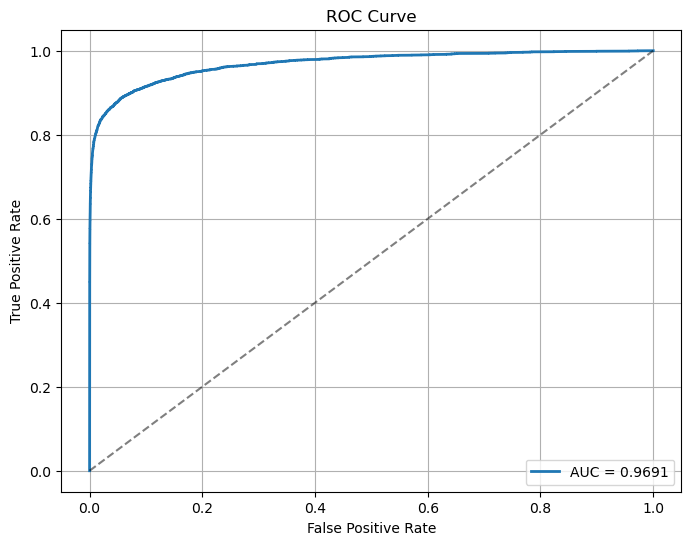

 AUC Score: 0.9691



In [29]:
# Train the model
lgb_model = train_lightgbm(X_train, y_train, X_val, y_val)

# Plot ROC & AUC
plot_roc_auc(lgb_model, X_val, y_val)


 Fraud distribution:
Train: 0.0350 (16530 frauds)
Val:   0.0350 (4133 frauds)

 Top features highly correlated with isFraud:
isFraud    1.000000
V45        0.236688
V86        0.224530
V87        0.224450
V44        0.218669
V52        0.201111
V51        0.187440
V40        0.178413
V79        0.173097
V39        0.170565
Name: isFraud, dtype: float64 

 Random Model AUC (baseline): 0.5069

 Re-training with weak features only: ['TransactionAmt', 'card1', 'card2', 'addr1']

 Training LightGBM model...
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.84976	val's auc: 0.830891
[200]	train's auc: 0.878365	val's auc: 0.850322
[300]	train's auc: 0.895321	val's auc: 0.861509
[400]	train's auc: 0.907786	val's auc: 0.868757
[500]	train's auc: 0.916814	val's auc: 0.873635
[600]	train's auc: 0.924244	val's auc: 0.877686
[700]	train's auc: 0.929942	val's auc: 0.880406
[800]	train's auc: 0.934991	val's auc: 0.883085
[900]	train's auc: 0.93966	val's auc: 0.885557
[

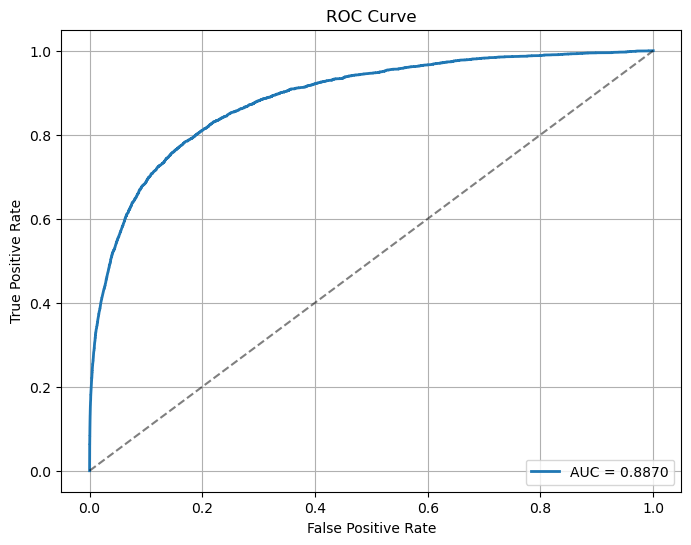

 AUC Score: 0.8870



In [30]:
from sklearn.metrics import roc_auc_score

# === 1. Check isFraud balance in train/val ===
def check_fraud_distribution(y_train, y_val):
    print(" Fraud distribution:")
    print(f"Train: {y_train.mean():.4f} ({y_train.sum()} frauds)")
    print(f"Val:   {y_val.mean():.4f} ({y_val.sum()} frauds)\n")

# === 2. Correlation with isFraud ===
def check_feature_correlation(df):
    print(" Top features highly correlated with isFraud:")
    corr = df.corr(numeric_only=True)['isFraud'].sort_values(key=abs, ascending=False)
    print(corr.head(10), "\n")

# === 3. Random prediction baseline ===
def check_random_auc(y_val):
    random_preds = np.random.rand(len(y_val))
    auc_random = roc_auc_score(y_val, random_preds)
    print(f" Random Model AUC (baseline): {auc_random:.4f}\n")

# === 4. Minimal feature model ===
def check_baseline_model(X_train, y_train, X_val, y_val):
    baseline_cols = [col for col in ['TransactionAmt', 'card1', 'card2', 'addr1'] if col in X_train.columns]
    if not baseline_cols:
        print(" Baseline features not in data.")
        return
    print(f" Re-training with weak features only: {baseline_cols}\n")
    X_base_train = X_train[baseline_cols]
    X_base_val = X_val[baseline_cols]
    
    model = train_lightgbm(X_base_train, y_train, X_base_val, y_val)
    plot_roc_auc(model, X_base_val, y_val)

# === Run All Checks ===
def run_sanity_checks(train_df, X_train, y_train, X_val, y_val):
    check_fraud_distribution(y_train, y_val)
    check_feature_correlation(train_df)
    check_random_auc(y_val)
    check_baseline_model(X_train, y_train, X_val, y_val)

# === Execute ===
run_sanity_checks(train_cleaned, X_train, y_train, X_val, y_val)


In [31]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [32]:
# If not installed
# !pip install xgboost

import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt


In [33]:
# Drop object columns (XGBoost can't handle categoricals directly)
def prepare_xgb_data(X):
    X = X.copy()
    X = X.select_dtypes(include=[np.number])
    return X.fillna(-999)  # Safe placeholder for missing values

X_train_xgb = prepare_xgb_data(X)
y_train_xgb = y.copy()


In [34]:
def xgb_cross_validation(X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []

    print(f" Starting {n_splits}-fold cross-validation...\n")

    for i, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = xgb.XGBClassifier(
            objective='binary:logistic',
            learning_rate=0.05,
            n_estimators=200,         # keep fixed to avoid early stopping
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            use_label_encoder=False,
            tree_method='hist'
        )

        # Set eval_metric via internal param update
        model.set_params(eval_metric='auc')

        model.fit(X_tr, y_tr)

        y_proba = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_proba)
        aucs.append(auc)

        fpr, tpr, _ = roc_curve(y_val, y_proba)
        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)

        print(f"Fold {i+1} AUC: {auc:.4f}")

    print(f"\n Mean AUC: {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")
    return aucs, mean_fpr, tprs


In [35]:
def plot_avg_roc_cv(mean_fpr, tprs):
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    plt.figure(figsize=(8, 6))
    plt.plot(mean_fpr, mean_tpr, label="Mean ROC (CV)", color='b')
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Mean ROC Curve from XGBoost Cross-Validation")
    plt.legend()
    plt.grid(True)
    plt.show()


 Starting 5-fold cross-validation...



c:\Users\aatis\anaconda3\envs\Data_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:40:54] WARNING: D:\bld\xgboost-split_1744329000128\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.9184


c:\Users\aatis\anaconda3\envs\Data_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:41:03] WARNING: D:\bld\xgboost-split_1744329000128\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.9182


c:\Users\aatis\anaconda3\envs\Data_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:41:13] WARNING: D:\bld\xgboost-split_1744329000128\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.9138


c:\Users\aatis\anaconda3\envs\Data_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:41:22] WARNING: D:\bld\xgboost-split_1744329000128\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.9164


c:\Users\aatis\anaconda3\envs\Data_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:41:32] WARNING: D:\bld\xgboost-split_1744329000128\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 5 AUC: 0.9169

 Mean AUC: 0.9167 ± 0.0017


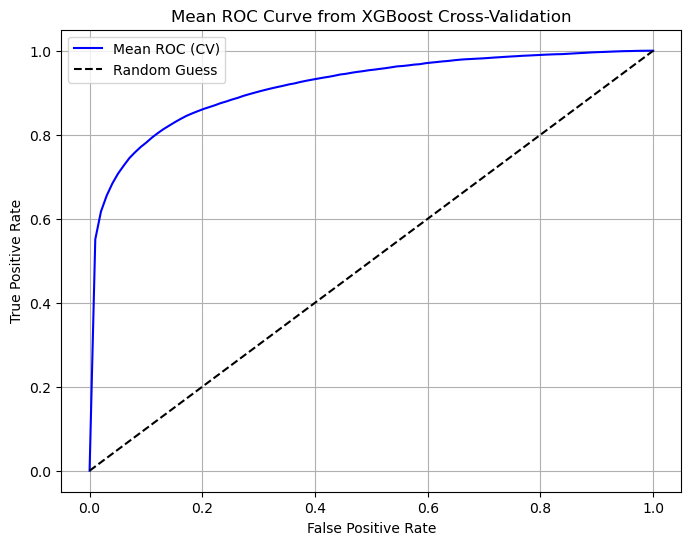

In [36]:
aucs, mean_fpr, tprs = xgb_cross_validation(X_train_xgb, y_train_xgb, n_splits=5)
plot_avg_roc_cv(mean_fpr, tprs)


In [37]:
# Use only numeric columns (same as XGBoost) and fill missing values
def prepare_lgbm_numeric(X):
    X = X.copy()
    X = X.select_dtypes(include=[np.number])
    return X.fillna(-999)  # Optional: LGBM can handle NaNs too

X_train_lgbm_restricted = prepare_lgbm_numeric(X_train)
X_val_lgbm_restricted = prepare_lgbm_numeric(X_val)


 Training LightGBM model...
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.940043	val's auc: 0.927257
[200]	train's auc: 0.959316	val's auc: 0.939994
[300]	train's auc: 0.968534	val's auc: 0.945479
[400]	train's auc: 0.975934	val's auc: 0.950475
[500]	train's auc: 0.98081	val's auc: 0.953829
[600]	train's auc: 0.9842	val's auc: 0.956036
[700]	train's auc: 0.986786	val's auc: 0.957503
[800]	train's auc: 0.989099	val's auc: 0.95939
[900]	train's auc: 0.990813	val's auc: 0.960889
[1000]	train's auc: 0.99227	val's auc: 0.961728
Did not meet early stopping. Best iteration is:
[999]	train's auc: 0.992266	val's auc: 0.96173
 Model training complete.

 Generating ROC curve...


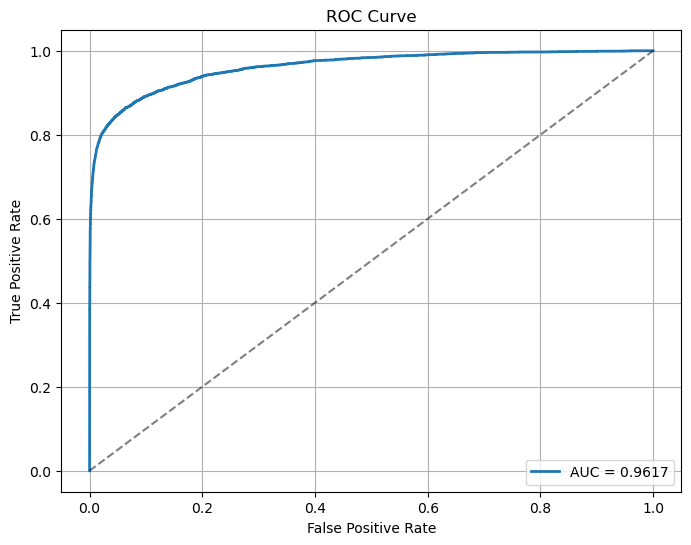

 AUC Score: 0.9617



In [38]:
# Use the same LightGBM training function you already have
lgb_model_restricted = train_lightgbm(
    X_train_lgbm_restricted,
    y_train,
    X_val_lgbm_restricted,
    y_val
)

# Plot ROC and print AUC
plot_roc_auc(lgb_model_restricted, X_val_lgbm_restricted, y_val)


In [39]:
from sklearn.preprocessing import OrdinalEncoder

# === Fit encoder on training data ===
def encode_full_dataset_fit(X):
    X = X.copy()

    # Force all categorical columns to string first
    cat_cols = X.select_dtypes(include=['object', 'category']).columns
    X[cat_cols] = X[cat_cols].astype(str)

    # Encode categorical features
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X[cat_cols] = encoder.fit_transform(X[cat_cols])

    # Ensure all columns are float
    for col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce')

    return X.fillna(-999), encoder

# === Transform val/test data with fitted encoder ===
def encode_full_dataset_transform(X, encoder):
    X = X.copy()

    cat_cols = X.select_dtypes(include=['object', 'category']).columns
    X[cat_cols] = X[cat_cols].astype(str)
    X[cat_cols] = encoder.transform(X[cat_cols])

    for col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce')

    return X.fillna(-999)


In [40]:
X_train_encoded, encoder = encode_full_dataset_fit(X_train)
X_val_encoded = encode_full_dataset_transform(X_val, encoder)


In [41]:
def train_xgboost_full(X_train, y_train, X_val, y_val):
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        learning_rate=0.05,
        n_estimators=300,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False,
        tree_method='hist'
    )

    model.set_params(eval_metric='auc')  # for older XGBoost versions
    model.fit(X_train, y_train)
    
    return model


c:\Users\aatis\anaconda3\envs\Data_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:42:39] WARNING: D:\bld\xgboost-split_1744329000128\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


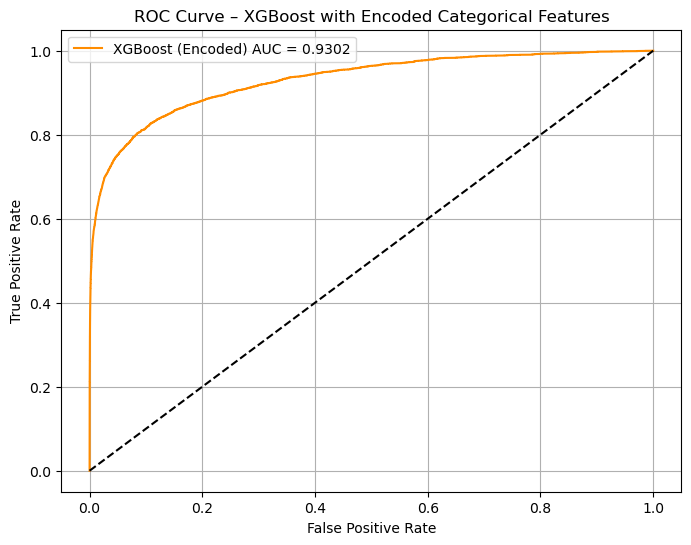

 AUC Score with Encoded XGBoost: 0.9302


In [42]:
xgb_model_encoded = train_xgboost_full(X_train_encoded, y_train, X_val_encoded, y_val)

# Evaluate
y_proba = xgb_model_encoded.predict_proba(X_val_encoded)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_proba)
auc_score = roc_auc_score(y_val, y_proba)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"XGBoost (Encoded) AUC = {auc_score:.4f}", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – XGBoost with Encoded Categorical Features")
plt.legend()
plt.grid(True)
plt.show()

print(f" AUC Score with Encoded XGBoost: {auc_score:.4f}")


In [43]:
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

# Minimal retraining setup
lgbm_sklearn_model = LGBMClassifier(
    objective='binary',
    learning_rate=0.05,
    num_leaves=64,
    n_estimators=1000,
    random_state=42
)

lgbm_sklearn_model.fit(
    X_train_lgbm_restricted, y_train,
    eval_set=[(X_val_lgbm_restricted, y_val)],
    eval_metric='auc',
    callbacks=[
        early_stopping(50),
        log_evaluation(100)
    ]
)


Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.927257	valid_0's binary_logloss: 0.0781339
[200]	valid_0's auc: 0.939994	valid_0's binary_logloss: 0.0710331
[300]	valid_0's auc: 0.945479	valid_0's binary_logloss: 0.0673008
[400]	valid_0's auc: 0.950475	valid_0's binary_logloss: 0.0644072
[500]	valid_0's auc: 0.953829	valid_0's binary_logloss: 0.0620434
[600]	valid_0's auc: 0.956036	valid_0's binary_logloss: 0.0603127
[700]	valid_0's auc: 0.957503	valid_0's binary_logloss: 0.0589728
[800]	valid_0's auc: 0.95939	valid_0's binary_logloss: 0.0576502
[900]	valid_0's auc: 0.960889	valid_0's binary_logloss: 0.0565417
[1000]	valid_0's auc: 0.961728	valid_0's binary_logloss: 0.0557013
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.96173	valid_0's binary_logloss: 0.0557109


LGBMClassifier(learning_rate=0.05, n_estimators=1000, num_leaves=64,
               objective='binary', random_state=42)

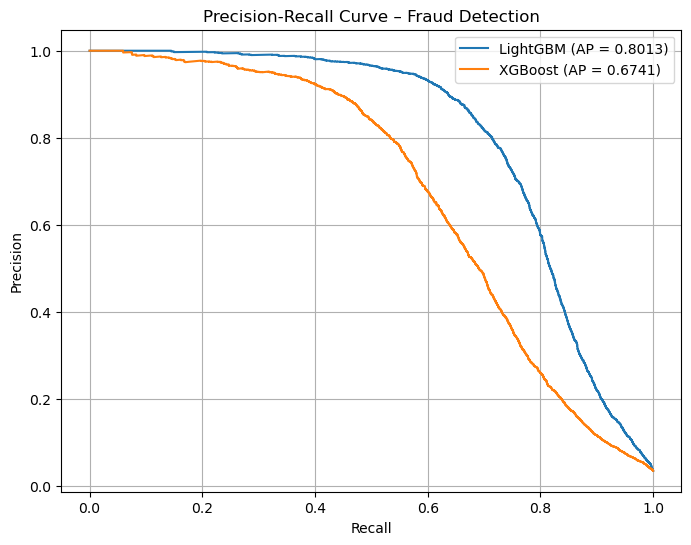

In [44]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# === Predict probabilities ===
y_proba_lgb = lgbm_sklearn_model.predict_proba(X_val_lgbm_restricted)[:, 1]
y_proba_xgb = xgb_model_encoded.predict_proba(X_val_encoded)[:, 1]

# === Compute PR curves ===
precision_lgb, recall_lgb, _ = precision_recall_curve(y_val, y_proba_lgb)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_val, y_proba_xgb)
# === Compute AUCs ===
ap_lgb = average_precision_score(y_val, y_proba_lgb)
ap_xgb = average_precision_score(y_val, y_proba_xgb)

# === Plot PR curves ===
plt.figure(figsize=(8, 6))
plt.plot(recall_lgb, precision_lgb, label=f"LightGBM (AP = {ap_lgb:.4f})")
plt.plot(recall_xgb, precision_xgb, label=f"XGBoost (AP = {ap_xgb:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve – Fraud Detection")
plt.grid(True)
plt.legend()
plt.show()

In [45]:
from sklearn.metrics import (
    f1_score, fbeta_score, classification_report,
    balanced_accuracy_score, confusion_matrix
)

# === Threshold for classification (you can tune this later)
threshold = 0.5

# === Convert probabilities to binary predictions
y_pred_lgb = (y_proba_lgb >= threshold).astype(int)
y_pred_xgb = (y_proba_xgb >= threshold).astype(int)

# === F1 and Fβ scores
f1_lgb = f1_score(y_val, y_pred_lgb)
f1_xgb = f1_score(y_val, y_pred_xgb)

fbeta_lgb = fbeta_score(y_val, y_pred_lgb, beta=2)
fbeta_xgb = fbeta_score(y_val, y_pred_xgb, beta=2)

# === Balanced Accuracy
bal_acc_lgb = balanced_accuracy_score(y_val, y_pred_lgb)
bal_acc_xgb = balanced_accuracy_score(y_val, y_pred_xgb)

# === Scikit-learn Reports
print(" LightGBM Classification Report:\n")
print(classification_report(y_val, y_pred_lgb, digits=4))

print(" XGBoost Classification Report:\n")
print(classification_report(y_val, y_pred_xgb, digits=4))

# === Summary Output
print("\n Summary Metrics:")

print(f"LightGBM")
print(f"  F1 Score          : {f1_lgb:.4f}")
print(f"  F2 Score (β=2)    : {fbeta_lgb:.4f}")
print(f"  Balanced Accuracy : {bal_acc_lgb:.4f}")

print(f"\n XGBoost")
print(f"  F1 Score          : {f1_xgb:.4f}")
print(f"  F2 Score (β=2)    : {fbeta_xgb:.4f}")
print(f"  Balanced Accuracy : {bal_acc_xgb:.4f}")


 LightGBM Classification Report:

              precision    recall  f1-score   support

           0     0.9846    0.9989    0.9917    113975
           1     0.9473    0.5693    0.7112      4133

    accuracy                         0.9838    118108
   macro avg     0.9659    0.7841    0.8514    118108
weighted avg     0.9833    0.9838    0.9819    118108

 XGBoost Classification Report:

              precision    recall  f1-score   support

           0     0.9798    0.9984    0.9890    113975
           1     0.9071    0.4321    0.5854      4133

    accuracy                         0.9786    118108
   macro avg     0.9434    0.7153    0.7872    118108
weighted avg     0.9772    0.9786    0.9749    118108


 Summary Metrics:
LightGBM
  F1 Score          : 0.7112
  F2 Score (β=2)    : 0.6187
  Balanced Accuracy : 0.7841

 XGBoost
  F1 Score          : 0.5854
  F2 Score (β=2)    : 0.4827
  Balanced Accuracy : 0.7153


c:\Users\aatis\anaconda3\envs\Data_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


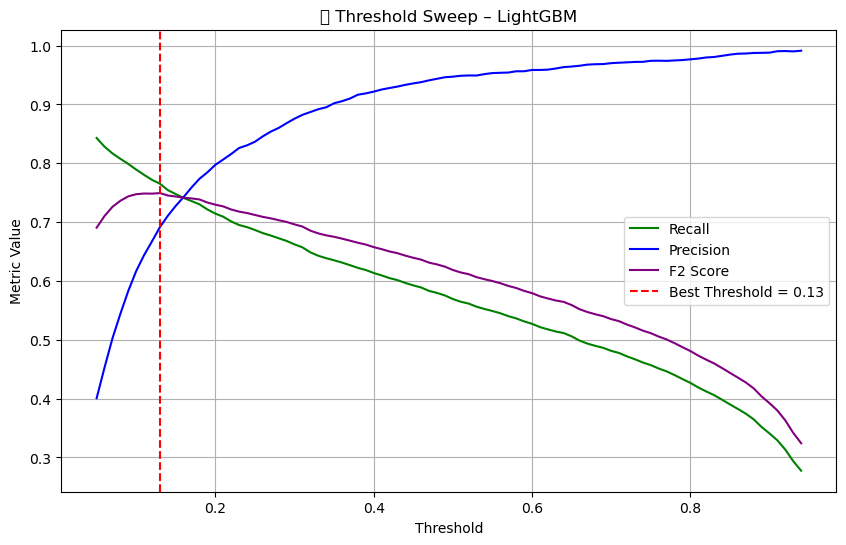

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, fbeta_score

thresholds = np.arange(0.05, 0.95, 0.01)
precisions = []
recalls = []
f2_scores = []

best_thresh = 0
best_f2 = 0

for t in thresholds:
    preds = (y_proba_lgb >= t).astype(int)
    p = precision_score(y_val, preds, zero_division=0)
    r = recall_score(y_val, preds)
    f2 = fbeta_score(y_val, preds, beta=2)
    
    precisions.append(p)
    recalls.append(r)
    f2_scores.append(f2)
    
    if f2 > best_f2:
        best_f2 = f2
        best_thresh = t

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, recalls, label="Recall", color="green")
plt.plot(thresholds, precisions, label="Precision", color="blue")
plt.plot(thresholds, f2_scores, label="F2 Score", color="purple")
plt.axvline(x=best_thresh, linestyle="--", color="red", label=f"Best Threshold = {best_thresh:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("🔍 Threshold Sweep – LightGBM")
plt.legend()
plt.grid(True)
plt.show()


In [47]:
from sklearn.metrics import classification_report

# Default threshold (0.5)
preds_default = (y_proba_lgb >= 0.5).astype(int)
recall_default = recall_score(y_val, preds_default)

# Best threshold
preds_best = (y_proba_lgb >= best_thresh).astype(int)
recall_best = recall_score(y_val, preds_best)

print(f" Default Threshold (0.5) Recall      : {recall_default:.4f}")
print(f" Best Threshold ({best_thresh:.2f}) Recall : {recall_best:.4f}")
print(f" F2 Score at Best Threshold          : {best_f2:.4f}")

print("\n Classification Report at Best Threshold:\n")
print(classification_report(y_val, preds_best, digits=4))


 Default Threshold (0.5) Recall      : 0.5693
 Best Threshold (0.13) Recall : 0.7653
 F2 Score at Best Threshold          : 0.7493

 Classification Report at Best Threshold:

              precision    recall  f1-score   support

           0     0.9915    0.9876    0.9895    113975
           1     0.6917    0.7653    0.7266      4133

    accuracy                         0.9798    118108
   macro avg     0.8416    0.8765    0.8581    118108
weighted avg     0.9810    0.9798    0.9803    118108



In [48]:
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix

# AUC and AUPRC (threshold-independent)
auc_lgb = roc_auc_score(y_val, y_proba_lgb)
auprc_lgb = average_precision_score(y_val, y_proba_lgb)

# Threshold-based predictions (you already chose 0.12)
threshold = 0.12
y_pred_thresh = (y_proba_lgb >= threshold).astype(int)

# Confusion matrix at threshold
cm = confusion_matrix(y_val, y_pred_thresh)

print(f" LightGBM Performance Summary (Threshold = {threshold:.2f})")
print(f"AUC       : {auc_lgb:.4f}")
print(f"AUPRC     : {auprc_lgb:.4f}")
print(f"Recall    : {recall_score(y_val, y_pred_thresh):.4f}")
print(f"Precision : {precision_score(y_val, y_pred_thresh):.4f}")
print(f"F1 Score  : {f1_score(y_val, y_pred_thresh):.4f}")
print(f"F2 Score  : {fbeta_score(y_val, y_pred_thresh, beta=2):.4f}")
print(f"Balanced Accuracy : {balanced_accuracy_score(y_val, y_pred_thresh):.4f}")

print("\n Confusion Matrix:")
print(cm)


 LightGBM Performance Summary (Threshold = 0.12)
AUC       : 0.9617
AUPRC     : 0.8013
Recall    : 0.7718
Precision : 0.6675
F1 Score  : 0.7159
F2 Score  : 0.7484
Balanced Accuracy : 0.8789

 Confusion Matrix:
[[112386   1589]
 [   943   3190]]


In [49]:
pip install catboost


Note: you may need to restart the kernel to use updated packages.


In [50]:
def prepare_for_catboost(X):
    X = X.copy()
    cat_cols = X.select_dtypes(include=['object', 'category']).columns

    # Replace NaNs with string 'missing' for object-type columns
    for col in cat_cols:
        X[col] = X[col].astype(str).fillna("missing")

    return X, cat_cols.tolist()


In [51]:
X_train_cb, cat_features_cb = prepare_for_catboost(X_train)
X_val_cb, _ = prepare_for_catboost(X_val)


In [52]:
from catboost import CatBoostClassifier, Pool

train_pool = Pool(X_train_cb, label=y_train, cat_features=cat_features_cb)
val_pool = Pool(X_val_cb, label=y_val, cat_features=cat_features_cb)

cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    random_seed=42,
    early_stopping_rounds=50,
    verbose=100
)

cat_model.fit(train_pool, eval_set=val_pool)


0:	test: 0.7074286	best: 0.7074286 (0)	total: 1.02s	remaining: 16m 58s
100:	test: 0.8796529	best: 0.8796529 (100)	total: 1m 26s	remaining: 12m 48s
200:	test: 0.8943424	best: 0.8943424 (200)	total: 2m 53s	remaining: 11m 30s
300:	test: 0.9020362	best: 0.9020362 (300)	total: 4m 20s	remaining: 10m 6s
400:	test: 0.9079133	best: 0.9079133 (400)	total: 5m 46s	remaining: 8m 37s
500:	test: 0.9118588	best: 0.9118588 (500)	total: 7m 13s	remaining: 7m 11s
600:	test: 0.9153798	best: 0.9153798 (600)	total: 8m 36s	remaining: 5m 43s
700:	test: 0.9184393	best: 0.9184393 (700)	total: 10m 21s	remaining: 4m 25s
800:	test: 0.9208736	best: 0.9208736 (800)	total: 11m 53s	remaining: 2m 57s
900:	test: 0.9226947	best: 0.9226947 (900)	total: 13m 24s	remaining: 1m 28s
999:	test: 0.9243485	best: 0.9243485 (999)	total: 14m 58s	remaining: 0us

bestTest = 0.9243484615
bestIteration = 999



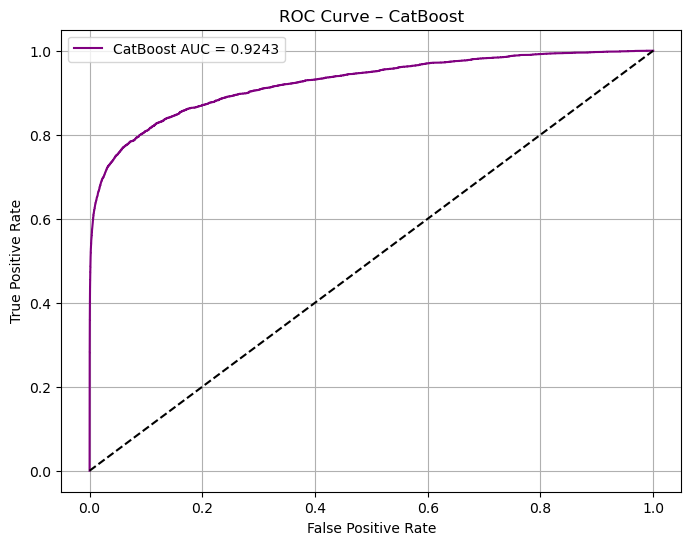

 Final CatBoost AUC: 0.9243


In [53]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_proba_cb = cat_model.predict_proba(X_val_cb)[:, 1]
fpr_cb, tpr_cb, _ = roc_curve(y_val, y_proba_cb)
auc_cb = roc_auc_score(y_val, y_proba_cb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_cb, tpr_cb, label=f"CatBoost AUC = {auc_cb:.4f}", color='purple')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – CatBoost")
plt.legend()
plt.grid(True)
plt.show()

print(f" Final CatBoost AUC: {auc_cb:.4f}")


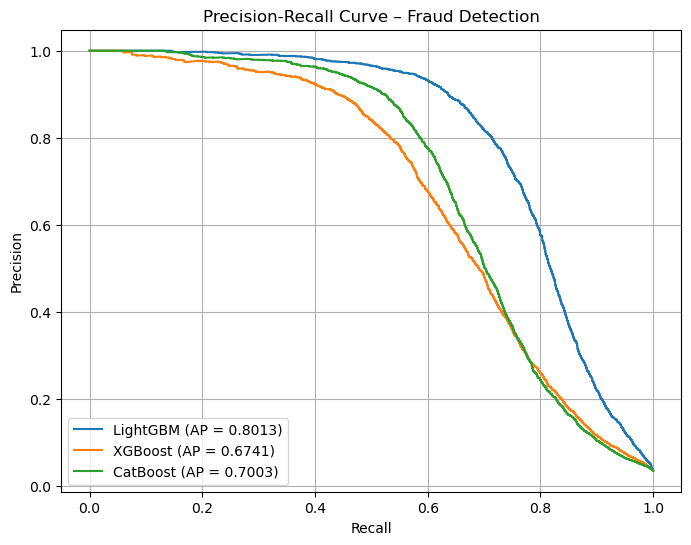

In [54]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# === Predict probabilities ===
y_proba_lgb = lgbm_sklearn_model.predict_proba(X_val_lgbm_restricted)[:, 1]
y_proba_xgb = xgb_model_encoded.predict_proba(X_val_encoded)[:, 1]
y_proba_cat = cat_model.predict_proba(X_val_cb)[:, 1]

# === Compute PR curves ===
precision_lgb, recall_lgb, _ = precision_recall_curve(y_val, y_proba_lgb)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_val, y_proba_xgb)
precision_cat, recall_cat, _ = precision_recall_curve(y_val, y_proba_cat)

# === Compute AUCs ===
ap_lgb = average_precision_score(y_val, y_proba_lgb)
ap_xgb = average_precision_score(y_val, y_proba_xgb)
ap_cat = average_precision_score(y_val, y_proba_cat)

# === Plot PR curves ===
plt.figure(figsize=(8, 6))
plt.plot(recall_lgb, precision_lgb, label=f"LightGBM (AP = {ap_lgb:.4f})")
plt.plot(recall_xgb, precision_xgb, label=f"XGBoost (AP = {ap_xgb:.4f})")
plt.plot(recall_cat, precision_cat, label=f"CatBoost (AP = {ap_cat:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve – Fraud Detection")
plt.grid(True)
plt.legend()
plt.show()


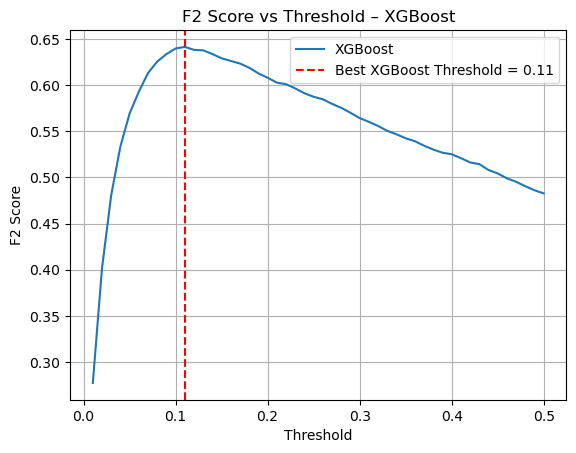

 XGBoost Best Threshold = 0.11
 F2 Score = 0.6415
 Classification Report at Best Threshold:
              precision    recall  f1-score   support

           0     0.9886    0.9750    0.9817    113975
           1     0.5000    0.6903    0.5799      4133

    accuracy                         0.9650    118108
   macro avg     0.7443    0.8326    0.7808    118108
weighted avg     0.9715    0.9650    0.9677    118108



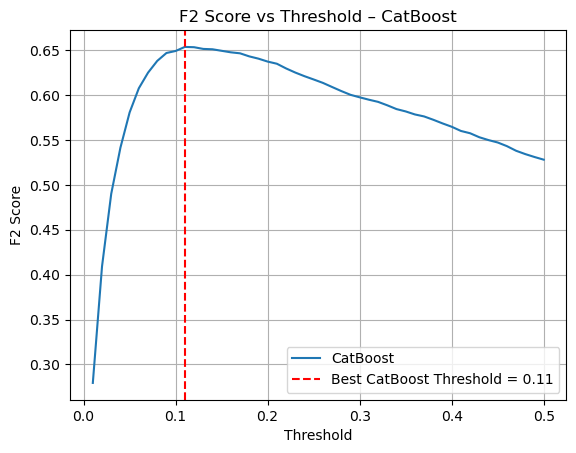

 CatBoost Best Threshold = 0.11
 F2 Score = 0.6536
 Classification Report at Best Threshold:
              precision    recall  f1-score   support

           0     0.9887    0.9782    0.9834    113975
           1     0.5355    0.6917    0.6037      4133

    accuracy                         0.9682    118108
   macro avg     0.7621    0.8350    0.7936    118108
weighted avg     0.9728    0.9682    0.9702    118108



In [55]:
from sklearn.metrics import fbeta_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

def find_best_threshold(y_true, y_proba, model_name="Model"):
    thresholds = np.linspace(0.01, 0.5, 50)
    f2_scores = []

    for t in thresholds:
        preds = (y_proba >= t).astype(int)
        f2 = fbeta_score(y_true, preds, beta=2)
        f2_scores.append(f2)

    # Best threshold
    best_idx = np.argmax(f2_scores)
    best_threshold = thresholds[best_idx]
    best_f2 = f2_scores[best_idx]

    # Plot F2 vs Threshold
    plt.plot(thresholds, f2_scores, label=model_name)
    plt.axvline(best_threshold, color='red', linestyle='--', label=f"Best {model_name} Threshold = {best_threshold:.2f}")
    plt.xlabel("Threshold")
    plt.ylabel("F2 Score")
    plt.title(f"F2 Score vs Threshold – {model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Classification report at best threshold
    preds_best = (y_proba >= best_threshold).astype(int)
    report = classification_report(y_true, preds_best, digits=4)

    print(f" {model_name} Best Threshold = {best_threshold:.2f}")
    print(f" F2 Score = {best_f2:.4f}")
    print(f" Classification Report at Best Threshold:\n{report}")

    return best_threshold, best_f2

# === Run for XGBoost and CatBoost ===
best_thresh_xgb, best_f2_xgb = find_best_threshold(y_val, y_proba_xgb, model_name="XGBoost")
best_thresh_cat, best_f2_cat = find_best_threshold(y_val, y_proba_cat, model_name="CatBoost")


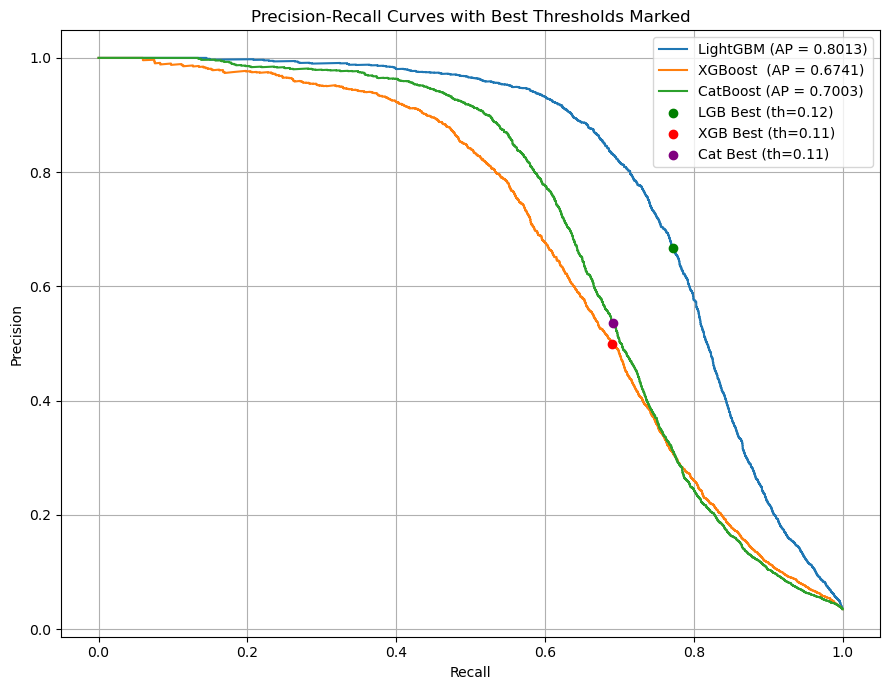

In [57]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# === Recompute precision and recall points ===
precision_lgb, recall_lgb, thresholds_lgb = precision_recall_curve(y_val, y_proba_lgb)
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_val, y_proba_xgb)
precision_cat, recall_cat, thresholds_cat = precision_recall_curve(y_val, y_proba_cat)

# === Compute AUPRC ===
ap_lgb = average_precision_score(y_val, y_proba_lgb)
ap_xgb = average_precision_score(y_val, y_proba_xgb)
ap_cat = average_precision_score(y_val, y_proba_cat)

# === Find the closest recall/precision pair to the best threshold ===
def get_precision_recall_at_threshold(thresholds, precision, recall, best_thresh):
    idx = np.argmin(np.abs(thresholds - best_thresh))
    return precision[idx], recall[idx]

# For LightGBM
best_thresh_lgb = 0.12
p_lgb_best, r_lgb_best = get_precision_recall_at_threshold(thresholds_lgb, precision_lgb[:-1], recall_lgb[:-1], best_thresh_lgb)

# For XGBoost and CatBoost 
p_xgb_best, r_xgb_best = get_precision_recall_at_threshold(thresholds_xgb, precision_xgb[:-1], recall_xgb[:-1], best_thresh_xgb)
p_cat_best, r_cat_best = get_precision_recall_at_threshold(thresholds_cat, precision_cat[:-1], recall_cat[:-1], best_thresh_cat)

# === Plot Precision-Recall curves ===
plt.figure(figsize=(9, 7))
plt.plot(recall_lgb, precision_lgb, label=f"LightGBM (AP = {ap_lgb:.4f})")
plt.plot(recall_xgb, precision_xgb, label=f"XGBoost  (AP = {ap_xgb:.4f})")
plt.plot(recall_cat, precision_cat, label=f"CatBoost (AP = {ap_cat:.4f})")

# Mark best threshold points
plt.scatter(r_lgb_best, p_lgb_best, color='green', label=f"LGB Best (th={best_thresh_lgb:.2f})", zorder=5)
plt.scatter(r_xgb_best, p_xgb_best, color='red', label=f"XGB Best (th={best_thresh_xgb:.2f})", zorder=5)
plt.scatter(r_cat_best, p_cat_best, color='purple', label=f"Cat Best (th={best_thresh_cat:.2f})", zorder=5)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves with Best Thresholds Marked")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
